# Проект Cleaned vs Dirty V2
### Задача и цели
Поставленная задача состоит в том, чтобы классифицировать тарелки как чистые или грязные. Учитывая набор данных из 20 чистых и 20 грязных тарелок для обучения и сотни тарелок в тестовом наборе, цель состоит в том, чтобы построить модель классификации изображений, которая может точно различать чистые и грязные тарелки.

Цель - автоматизировать процесс определения чистой посуды, чтобы сэкономить время.

[Датасет](https://www.kaggle.com/competitions/platesv2/overview)

In [ ]:
# импортируем все нужные библиотеки
import os
import pandas as pd
import shutil
import zipfile
import kagglehub
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Очищает содержимое папки, если она существует.
def clear_folder(folder_path):
    if os.path.isdir(folder_path):
        print(f"Папка '{folder_path}' существует. Очистка содержимого...")

        # Удаляем все файлы и подпапки внутри папки
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    # Удаляем файл или символическую ссылку
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    # Рекурсивно удаляем подпапку
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f"Ошибка при удалении {file_path}: {e}")
    else:
        print(f"Папка '{folder_path}' не существует. Создание новой папки...")
        # Создаем папку, если её нет
        os.makedirs(folder_path, exist_ok=True)

### 1. Загрузить и обработать данные

Перед вводом данных в модель необходима предварительная обработка для повышения четкости и надежности характеристик.

Будет сделано следующее:
* все изображения будут изменены до одинакового размера 64 * 64;
* значения пикселей будут нормализованы до диапазона [0, 1] для улучшения сходимости во время обучения
* для искусственного увеличения разнообразия обучающего набора данных будут применяться такие методы, как поворот, переворачивание и регулировка яркости, афинные преобразования, то есть сделана аугментация данных

Чтобы скачать датасет с kaggle, был скачен токен с kaggle и конфигурационный файл положила на google диска

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c platesv2
!unzip platesv2.zip -d platesv2

Archive:  platesv2.zip
  inflating: platesv2/plates.zip     
  inflating: platesv2/sample_submission.csv  


In [ ]:
# Путь к архиву и целевой папке
archive_path = 'platesv2/plates.zip'
target_folder = 'data_platesv2'

# Создать целевую папку (если её нет)
clear_folder(target_folder)
os.makedirs(target_folder, exist_ok=True)

# Распаковать архив
with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)

print('Архив успешно распакован!')

Папка 'data_platesv2' не существует. Создание новой папки...
Архив успешно распакован!


In [ ]:
# Трансформеры для тренировочной выборки
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Трансформеры аугментации
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(30),  # Случайный поворот на ±30 градусов
    transforms.RandomHorizontalFlip(p=0.5),  # Горизонтальное переворачивание
    transforms.RandomVerticalFlip(p=0.5),  # Вертикальное переворачивание
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Регулировка яркости
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10) # Афинные преобразования
])

# Аугментировать изображения
def augment_image(image, n_augmentations=1):
    augmented_images = [image]
    for _ in range(n_augmentations):
        augmented_image = augmentation_transforms(image)
        augmented_images.append(augmented_image)
    return augmented_images


def augment_dataset(dataset_path, output_path, n_augmentations=1):
    valid_img_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff']
    # Создаем папку для сохранения
    os.makedirs(output_path, exist_ok=True)

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        output_class_path = os.path.join(output_path, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        # Если не папка класса, то пропускаем
        if not os.path.isdir(class_path):
          continue

        for image_name in os.listdir(class_path):
            name, ext = os.path.splitext(image_name)
            # Если не картинка, то пропускаем
            if ext not in valid_img_extensions:
              continue

            image_path = os.path.join(class_path, image_name)
            image = Image.open(image_path).convert("RGB")

            # Аугментируем изображение
            augmented_images = augment_image(image, n_augmentations)

            # Сохраняем оригинальное и аугментированные изображения
            for i, aug_image in enumerate(augmented_images):
                if i == 0:
                    aug_image.save(os.path.join(output_class_path, f"original_{image_name}"))
                else:
                    aug_image.save(os.path.join(output_class_path, f"aug_{i}_{image_name}"))

In [ ]:
# Констатнты
DATA_PATH = 'data_platesv2'
TRAIN_DATA_PATH = f'{DATA_PATH}/plates/train'
TRAIN_DATA_PATH_AUG = f'{DATA_PATH}/plates/train_aug'
TEST_DATA_PATH = f'{DATA_PATH}/plates/test'
BATCH_SIZE = 16
CLASSES = {0:'Чистая', 1:'Грязная'}

In [ ]:
# Аугментируем датасет
augment_dataset(TRAIN_DATA_PATH, TRAIN_DATA_PATH_AUG, n_augmentations=5)
# Удалить лишний файл, не знаю откуда появляется, даже в скрытых не показывается
!find data_platesv2/plates/train_aug -name ".DS_Store" -delete
!find data_platesv2/plates/train -name ".DS_Store" -delete
!find data_platesv2/plates/test -name ".DS_Store" -delete

In [ ]:
# Загрузить данные
train_dataset = datasets.ImageFolder(root=TRAIN_DATA_PATH_AUG, transform=transform)

# Разделим train_dataset на тренировочную и валидационную части
train_size = int(0.8 * len(train_dataset))  # 80% для тренировки
val_size = len(train_dataset) - train_size  # 20% для валидации
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
print(f'Размер тренировачного датасета: {len(train_subset)}')
print(f'Размер валидационного датасета: {len(val_subset)}')

# Создать загрузчик данных для тренировочной и валидационной выборок
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

Размер тренировачного датасета: 192
Размер валидационного датасета: 48


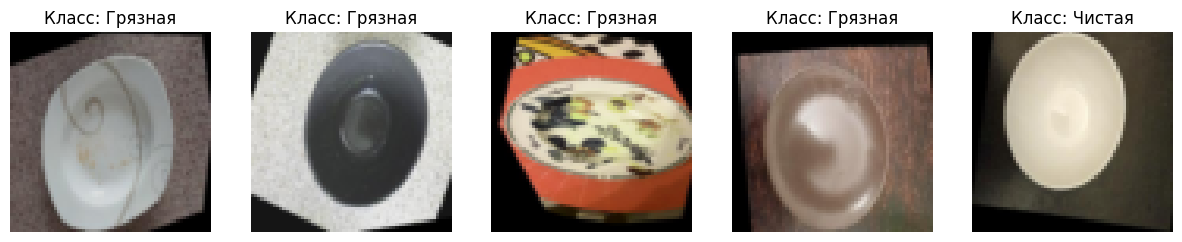

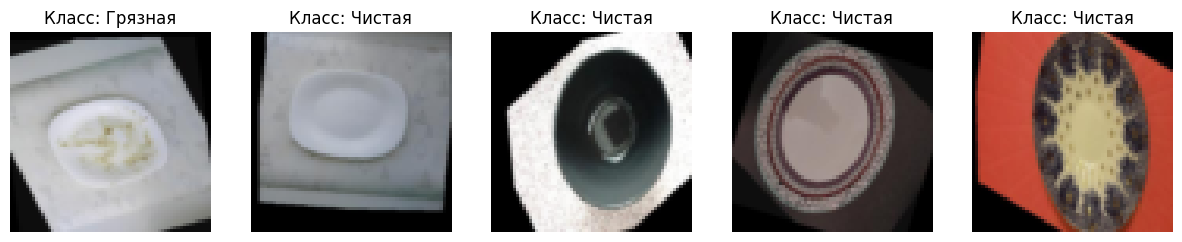

In [ ]:
# Посмотреть наши данные
def visualize_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        # Берём рандомную картинку в датасете
        index = torch.randint(0, len(dataset), (1,)).item()
        img, label = dataset[index]

        # Денормализовать обратно картинку для просмотра
        img = img * 0.5 + 0.5

        # Конвектировать tensor к масиву NumPy для просмотра
        img = np.transpose(img.numpy(), (1, 2, 0))

        # Отобразить картинку
        axes[i].imshow(img)
        axes[i].set_title(f'Класс: {CLASSES[label]}')
        axes[i].axis('off')
    plt.show()

visualize_images(train_dataset)
visualize_images(val_subset)

### 2. Создать модель и обучить
У нас всего 40 изображений для обучения (20 чистых и 20 грязных). Несмотря на то что я искуственно расширила датасет, такой объем данных недостаточен для полноценного обучения большой модели с нуля. Использование предобученной модели позволяет использовать уже извлеченные признаки из ImageNet и адаптировать их под нашу задачу. То есть предобученная модель будет использоваться для извлечения значимых функций из ограниченных данных. Последние слои предварительно обученной модели будут заменены пользовательскими плотными слоями, адаптированными к нашей задаче бинарной классификации.

Гиперпараметры модели:
* небольшая скорость обучения 0,001 будет использоваться для предотвращения превышения во время оптимизации;
* размер пакета выбран 16;
* реализована ранняя остановка, чтобы избежать переобучения;
* Adam optimizer будет использоваться для эффективного градиентного спуска.

Гиперпараметры были выбраны как стандартные для задач fine-tuning с использованием предобученных моделей. Они обеспечивают стабильное и быстрое обучение, что особенно важно для маленьких датасетов.

In [ ]:
# Загружаем предобученую модель resnet18
base_model = models.resnet18(pretrained=True)

# Заменям последние слои под нашу задачу бинарной классификации, где два класса будет: чистая и грязная тарелка
num_features = base_model.fc.in_features
base_model.fc = nn.Linear(num_features, 2)

# Переносим расчёт на GPU по возможности, чтобы быстрее происходили вычисления
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = base_model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


In [ ]:
# Вычислить точность модели на данных
def evaluate_model(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# Обученить модель
def train(model, train_loader, val_loader, n_epoch=10):
  # Функция потерь и оптимизатор
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # Списки для хранения значений метрик
  train_losses, val_losses = [], []
  train_accs, val_accs = [], []

  for epoch in range(n_epoch):
      model.train()
      running_loss = 0.0

      # Обучение на тренировочных данных
      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          # Обнуление градиентов
          optimizer.zero_grad()

          # Прямой проход
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          # Сохраненить значение потерь за эпоху
          train_losses.append(running_loss / len(train_loader))

          # Обратный проход и оптимизация
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      # Оценка точности на тренировочных и валидационных данных
      train_accuracy = evaluate_model(model, train_loader)
      val_accuracy = evaluate_model(model, val_loader)

      train_accs.append(train_accuracy)
      val_accs.append(val_accuracy)

      print(f'Эпоха {epoch+1}/{n_epoch}, Loss: {train_losses[-1]:.3f}, '
            f'Train acc: {train_accuracy * 100:.3f}%, '
            f'Val acc: {val_accuracy * 100:.3f}%')

  return train_losses, train_accs, val_accs

# Построенть графики обучения
def show_train_metrics(train_losses, train_acc, val_acc):
  plt.figure(figsize=(12, 5))

  # График потерь
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Потеря обучения')
  plt.title('Потеря обучения')
  plt.xlabel('Эпоха')
  plt.ylabel('Значение потерь')
  plt.legend()

  # График точности
  plt.subplot(1, 2, 2)
  plt.plot(train_acc, label='Точность обучения')
  plt.plot(val_acc, label='Точность валидации')
  plt.title('Оценка точности модели на обучающей и валидационной выборке')
  plt.xlabel('Эпоха')
  plt.ylabel('Точность')
  plt.legend()

  plt.show()

Эпоха 1/10, Loss: 1.302, Train acc: 81.771%, Val acc: 58.333%
Эпоха 2/10, Loss: 0.729, Train acc: 77.083%, Val acc: 60.417%
Эпоха 3/10, Loss: 0.369, Train acc: 89.062%, Val acc: 58.333%
Эпоха 4/10, Loss: 0.253, Train acc: 92.188%, Val acc: 81.250%
Эпоха 5/10, Loss: 0.234, Train acc: 98.438%, Val acc: 77.083%
Эпоха 6/10, Loss: 0.108, Train acc: 97.396%, Val acc: 64.583%
Эпоха 7/10, Loss: 0.182, Train acc: 94.792%, Val acc: 75.000%
Эпоха 8/10, Loss: 0.101, Train acc: 98.958%, Val acc: 72.917%
Эпоха 9/10, Loss: 0.036, Train acc: 99.479%, Val acc: 72.917%
Эпоха 10/10, Loss: 0.029, Train acc: 99.479%, Val acc: 77.083%


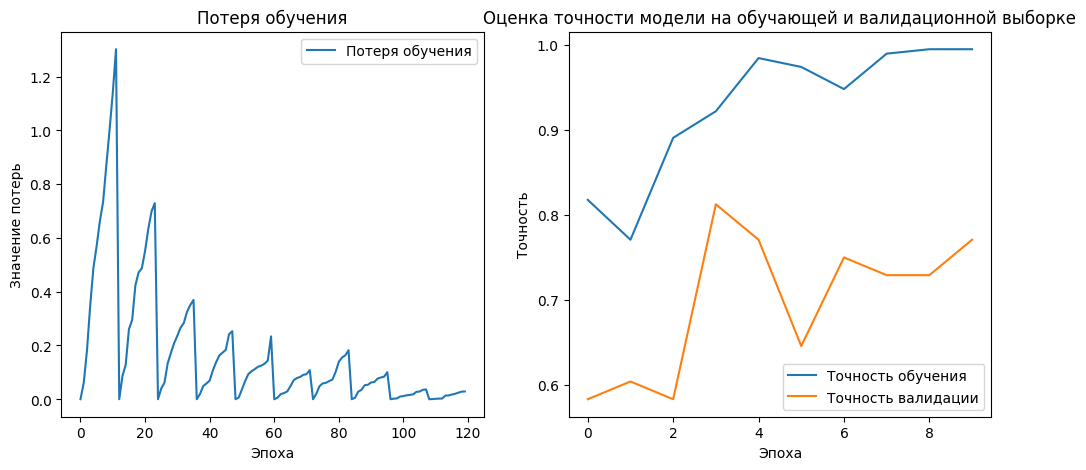

In [ ]:
# Обучить модель и нарисовать графики обучения
train_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, n_epoch=10)
show_train_metrics(train_losses, train_accuracies, val_accuracies)

In [ ]:
# Сохранить модель после обучения
model_save_path = "dish_classifier.pth"
torch.save(model.state_dict(), model_save_path)

### 3. Оценить качество модели

In [ ]:
# Оценить качество модели по всем метрикам классификации
def evaluate_model_metrics(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Вычисление полного отчета по метрикам
    report = classification_report(all_labels, all_preds, target_names=['Clean', 'Dirty'], output_dict=True)
    print('Отчёт о классификации:\n', classification_report(all_labels, all_preds, target_names=['Clean', 'Dirty']))

    return report

# Отобразить картинки с предсказаниями
def visualize_predictions(model, data_loader, n_images=3):
    model.eval()
    fig, axes = plt.subplots(1, n_images, figsize=(15, 3))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            if i >= n_images:
                break
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Денормализация изображения
            img = inputs[0].cpu() * 0.5 + 0.5
            img = np.transpose(img.numpy(), (1, 2, 0))

            # Отображение изображения с предсказанием
            axes[i].imshow(img)
            axes[i].set_title(f'Предсказанная: {CLASSES[preds[0].item()]}, Настоящая: {CLASSES[labels[0].item()]}')
            axes[i].axis('off')
    plt.show()

In [ ]:
# Загрузка модели
loaded_model = models.resnet18(pretrained=False)
num_features = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_features, 2)
loaded_model = loaded_model.to(device)

# Загрузка весов из файла
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.eval()  # Переключение модели в режим оценки
print('Модель загружена!')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Модель загружена!


Отчёт о классификации:
               precision    recall  f1-score   support

       Clean       0.79      0.76      0.78        25
       Dirty       0.75      0.78      0.77        23

    accuracy                           0.77        48
   macro avg       0.77      0.77      0.77        48
weighted avg       0.77      0.77      0.77        48



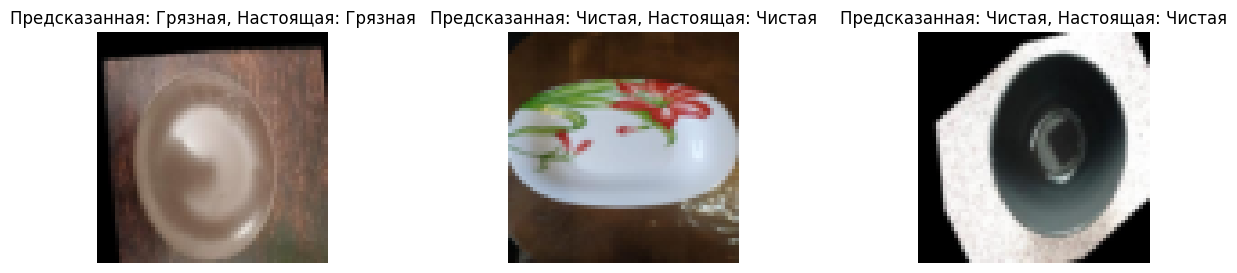

In [ ]:
# Оценка модели на тестовых данных и отобразить предсказания
report = evaluate_model_metrics(model, val_loader)
visualize_predictions(model, val_loader)

### Выводы по обучению предобученной модели:
* Модель обучена на относительно небольшом датасете, что может быть причиной некоторой разницы между точностями на тренировочной и валидационной выборках. Мы обучали на предобученной модели resnet18, а она требует данных намного больше, чем первоначальный датасет (слишком маленький, примерно 20 изображений на каждый класс), поэтому, чтобы модель показала результат не совсем плачевный, я расширила датасет с помощью аугментирования данных. В итоге, модель демонстрирует адекватную обобщающую способность, так как точность на валидации остается на приемлемом уровне.
* Потери (Loss) снижаются с ростом числа эпох, что указывает на успешное обучение модели. К концу обучения (эпоха 10), значение потерь достигает низкого уровня (~0.029), что говорит о хорошей сходимости модели.
* Точность на тренировочной выборке быстро растет до высоких значений (>97%) к концу обучения. Точность на валидационной выборке также увеличивается, но менее стабильно по сравнению с тренировочной точностью.
В конце обучения точность на валидационной выборке составляет 77%, что ниже, чем на тренировочной выборке ( 99.479%). Это указывает на некоторую разницу между производительностью на тренировочных и валидационных данных, но она не является критической.
* Модель показывает баланс между Precision и Recall для обоих классов, что свидетельствует о достаточно устойчивой работе. F1-score, который является гармоническим средним Precision и Recall, также находится на приемлемом уровне (0.77). Общая точность составляет 77%, что является удовлетворительным результатом для задачи классификации чистых и грязных тарелок.

### 4. Протестировать модель на тестовых данных
Так как у тестовых данных нет меток, то мы сами создадим условный датесет с тестовыми данными и проверим модель на них. Предсказания сохраним в файле.

In [ ]:
# Загрузить данные без меток
class UnlabeledDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Возвращать путь к изображению вместо метки
        return image, img_path

# Трансформеры для тестовых данных
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Создать датасет и загрузчик
test_dataset = UnlabeledDataset(root_dir=TEST_DATA_PATH, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Получить предсказания на тестовых данных без истинных меток
def predict_on_unlabeled_data(model, data_loader):
    model.eval()
    predictions = []
    image_paths = []

    with torch.no_grad():
        for inputs, paths in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            image_paths.extend(paths)

    # Сохраненить результатов в DataFrame
    results = pd.DataFrame({
        'Путь к картинке': image_paths,
        'Предсказание': ['Clean' if pred == 0 else 'Dirty' for pred in predictions]
    })

    return results

# Получить предсказания
results = predict_on_unlabeled_data(loaded_model, test_loader)

# Сохраненить результаты в CSV
results.to_csv('predictions.csv', index=False)

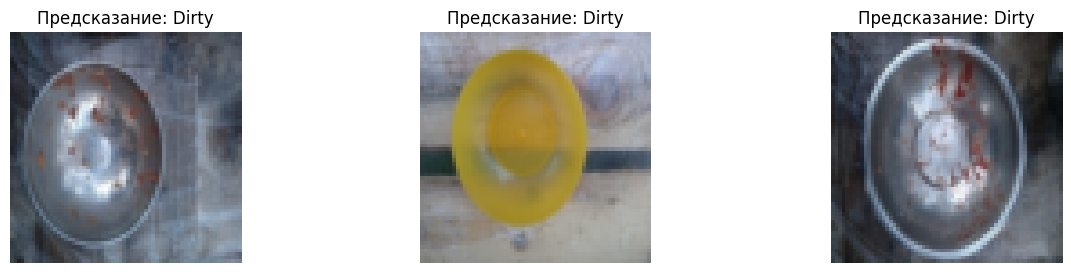

In [ ]:
# Визуализировать предсказания на тестовых данных без истинных меток
def visualize_predictions_unlabeled(results, n_images=3):
    fig, axes = plt.subplots(1, n_images, figsize=(15, 3))

    for i, row in results.iterrows():
        if i >= n_images:
            break

        img_path = row['Путь к картинке']
        predicted_class = row['Предсказание']

        # Загрузить и преобразовать изображения
        img = Image.open(img_path).convert("RGB")
        img = test_transform(img)
        # Денормализация
        img = img * 0.5 + 0.5
        img = np.transpose(img.numpy(), (1, 2, 0))

        # Показать картинку
        axes[i].imshow(img)
        axes[i].set_title(f'Предсказание: {predicted_class}')
        axes[i].axis('off')

    plt.show()

# Визуализация предсказаний
visualize_predictions_unlabeled(results)

### Выводы:
Модель успешно решает задачу классификации чистых и грязных тарелок с приемлемым уровнем точности (77%) и балансом между Precision и Recall. Однако для дальнейшего улучшения можно увеличить размер датасета, провести дополнительную аугментацию данных и протестировать различные гиперпараметры или архитектуры моделей.